# Weight tracking, analysis and forecast

## Setup

In [1]:
import numpy as np
import csv
import datetime
from datetime import date
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import os
import sys
import pandas as pd
import seaborn as sns
import tensorflow as tf

from zipfile import ZipFile

In [2]:
print(f'Python = {sys.version}')
print(f'Numpy = {np.__version__}')
print(f'Tensorflow = {tf.__version__}')

Python = 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]
Numpy = 1.20.3
Tensorflow = 2.5.0


# Data Extraction

=> file "data_BEN.zip" contains the file "weight.csv" with all daily measurements of total mass, fat mass.

=> file "Suivi_Poids.csv" has manually-entered daily numbers for total mass and fat mass, plus nutrition data (lipid, carbs, proteines), and calories data (ingested, spent with cardio, spent with strength training)

In [3]:
ROOT = os.getcwd() + '/'
print(f'current working directory is {ROOT}')
print(f'contains :')
print(f'{os.listdir(ROOT)}')

current working directory is c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/
contains :
['.git', '.ipynb_checkpoints', 'data_BEN.zip', 'desktop.ini', 'model.png', 'pat.txt', 'polar-user-data-export.zip', 'README.md', 'Suivi_Poids.csv', 'test_methodes.xlsx', 'tmp', 'weight.ipynb', 'weight_arima.ipynb', 'weight_rapport.ipynb', 'weight_recherche.ipynb']


In [4]:
class GetData():
    
    """
    Basic class to to all the data extraction work :
    - extracts the two files
    - replaces manually entered numbers for total mass and fat mass by calculated averages if available
    - provides method to export processed data
    """
    
    def __init__(self, zip_file_name, manual_file_name):
        self.zip_file_name = zip_file_name
        self.manual_follow_up_file_name = manual_file_name
        self.daily_mass_measurements = []
        self.daily_data = []
    
    def extract(self):
        # extract data from the two files
        # first : data_BEN.zip
        
        root = os.getcwd() + '/'
        weight_file_path = root + 'tmp'

        with ZipFile(self.zip_file_name, 'r') as fichier_zip:
            print(f'Extraction fichier Zip Healthmate dans {weight_file_path}...')
            fichier_zip.extractall(path = weight_file_path)
            print(f'... Done')
        
        weight_file_csv_name = weight_file_path + '/weight.csv'
        fields = ['date', 
                  'MT', 
                  'MG']

        self.raw_from_zip = self.__extract_data(weight_file_csv_name, 
                                                fields,
                                                skip=1, 
                                                delimiter=',')  # gets a list of dictionnaries
        
        # 1/ self.raw_from_zip is a list of dictionnaries, that's the set of all mass measurements from Withings scale
        # there can be several measurements per day (and there usually are)
        
        # format is :
        # [ { 'date' : 'YYYY-MM-DD time', 'MT' : str of total mass, 'MG' : str of fat mass, None : ['','','']},
        #   { 'date' : 'YYYY-MM-DD time', 'MT' : str of total mass, 'MG' : str of fat mass, None : ['','','']},
        #   ....,
        #   { 'date' : 'YYYY-MM-DD time', 'MT' : str of total mass, 'MG' : str of fat mass, None : ['','','']},
        # ]
                
        # second : Suivi_Poids.csv
        
        fields = ['date', 
                  'Masse Totale', 
                  'Masse Grasse', 
                  'Calories in', 
                  'Glucides', 'Lipides', 'Proteines', 
                  'Calories Exercice Brut', 'C_Ex_Cardio', 'C_Ex_Strength',
                  'Verif']
        
        self.raw_from_manual = self.__extract_data(self.manual_follow_up_file_name, 
                                                   fields,
                                                   skip=2, 
                                                   delimiter=';')  # returns and stores a list of disctionnaries
              
        
        # 2/ self.raw_from_manual is a list of dictionnaries, with one set of data per day, from a *.csv follow-up file
        
        # format is :
        # [ { 'date' : 'DD-month_name-YYYY', 'Masse Totale' : str of total mass, 'Masse Grasse' : str of fat mass,
        #     'Calories In' : str of kcals, 'Glucides' : str, 'Lipides' : str, 'Proteines' : str, 'Calories Exercice Brut': str,
        #     'C_Ex_Cardio': str, 'C_Ex_Strength': str, 'Verif': str, None: ['', '']
        #   },
        # ....
        # ]
        
        # ------------------------------
        # -- data consolidation --------
        # ------------------------------
        
        # 1/ creates an attribute self.daily_mass_measurements, which is a list of dictionnaries, containing all the mass measurements
        # per day, non empty, in float format - created from self.raw_from_zip
        
        # format is :
        
        # [ { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   ...
        # ]
        
        for cdict in self.raw_from_zip:
            cdate = self.__conv_to_date_num(cdict.get('date'))
            cmt = self.__conv_to_float(cdict.get('MT'))
            cmg = self.__conv_to_float(cdict.get('MG'))
            self.__add_daily_mass_measurement(cdate, cmt, cmg)
            
        # 2/ creates an attribute self.daily_data, which is a list of dictionnaries, containing all the measurements of the day
        # plus the calories data from the *.csv file (self.raw_from_manual)
        # if available in self.daily_mass_measurements, then the mass data in self.daily_data is overwritten by the averages
        # in self.daily_mass_measurements
        
        # format is :
        
        # [ { 'date' : date_object, 'masse_totale' : total mass (float), 'masse_grasse' : fat mass (float),
        #     'calories_in' : kcals (float), 'glucides' : float, 'lipides' : float, 'proteines' : float, 'calories_exercice': float,
        #     'calories_cardio': float, 'calories_strength': float },
        # ....
        # ]
        
        for cdict in self.raw_from_manual:
            cdate = self.__conv_to_date_str(cdict.get('date'))
            found, cmt, cmg = self.get_daily_mass_measurement(cdate)  # is the mass data in the Withings file ?
            if found:
                cmt = np.mean(cmt)
                cmg = np.mean(cmg)
            else:
                cmt = self.__conv_to_float(cdict.get('Masse Totale'))
                cmg = self.__conv_to_float(cdict.get('Masse Grasse'))
            cals_in = self.__conv_to_float(cdict.get('Calories in', '0.0'))
            glu = self.__conv_to_float(cdict.get('Glucides', '0.0'))
            lip = self.__conv_to_float(cdict.get('Lipides','0.0'))
            prot = self.__conv_to_float(cdict.get('Proteines', '0.0'))
            cals_ex = self.__conv_to_float(cdict.get('Calories Exercice Brut', '0.0'))
            cals_card = self.__conv_to_float(cdict.get('C_Ex_Cardio', '0.0'))
            cals_str = self.__conv_to_float(cdict.get('C_Ex_Strength', '0.0'))
            new_rec = dict([ ('date', cdate), 
                             ('masse_totale', cmt),
                             ('masse_grasse', cmg),
                             ('calories_in', cals_in),
                             ('glucides', glu),
                             ('lipides', lip),
                             ('proteines', prot),
                             ('calories_exercice', cals_ex),
                             ('calories_cardio', cals_card),
                             ('calories_strength', cals_str)
                             ])
            self.daily_data.append(new_rec)            
                    
    def __add_daily_mass_measurement(self, cdate : datetime.datetime, cmt : float, cmg : float):
        # utility : add cmt, cmg to the self.daily_mass_measurements records, or create it if first time
        found = False
        for i, daily_m_dict in enumerate(self.daily_mass_measurements):
            if daily_m_dict.get('date') == cdate:
                found = True
                self.daily_mass_measurements[i]['mt'].append(cmt)
                self.daily_mass_measurements[i]['mg'].append(cmg)
        if not found:
            new_rec = dict([ ('date', cdate), ('mt', [cmt]) , ('mg', [cmg]) ])
            self.daily_mass_measurements.append(new_rec)
            
    def get_daily_mass_measurement(self, cdate : datetime.datetime):
        # access to list of daily mass measurements
        # returns :
        # (True, list of mt measurements, list of mg measurements) if exist
        # (False, 0.0, 0.0) if does not exist
        found = False
        daily_mt = 0.0
        daily_mg = 0.0
        
        for i, daily_m_dict in enumerate(self.daily_mass_measurements):
            if daily_m_dict.get('date') == cdate:
                found = True
                daily_mt = daily_m_dict.get('mt')
                daily_mg = daily_m_dict.get('mg')
                
        return found, daily_mt, daily_mg
    
    def get_window_daily_mass_measurements(self, start_date : datetime.datetime, end_date : datetime.datetime):
        # return a list of dictionnaries, being the extract of daily_mass_measurements between the two dates
        # format is, for the relevant dates :
        # [ { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   ...
        # ]
        
        if start_date >= end_date:
            raise NameError('Requesting window with start date posterior to end date')
        
        duration = (end_date - start_date).days
        dates_list = [ start_date + datetime.timedelta(days = d) for d in range(duration) ]
        window = []
        
        for cdate in dates_list:
            found, daily_mt, daily_mg = self.get_daily_mass_measurement(cdate)
            if found:
                window.append( dict([ ('date',cdate), ('mt',daily_mt), ('mg', daily_mg) ]) )
                
        return window
    
    def get_daily_data(self, cdate : datetime.datetime):
        # access to list of daily data
        
        # returns :
        # (True, dict of dialy data if exist
        # (False, {}) if does not exist
        found = False
        ret_dict = {}
        
        for i, daily_m_dict in enumerate(self.daily_data):
            if daily_m_dict.get('date') == cdate:
                found = True
                ret_dict = self.daily_data[i]
                
        return found, ret_dict
    
    def get_window_daily_data(self, start_date : datetime.datetime, end_date : datetime.datetime):
        # return a list of dictionnaries, being the extract of the daily data between the two dates
        # format is, for the relevant dates :
        
        # [ { 'date' : date_object, 'masse_totale' : total mass (float), 'masse_grasse' : fat mass (float),
        #     'calories_in' : kcals (float), 'glucides' : float, 'lipides' : float, 'proteines' : float, 'calories_exercice': float,
        #     'calories_cardio': float, 'calories_strength': float },
        # ....
        # ]
        
        if start_date >= end_date:
            raise NameError('Requesting window with start date posterior to end date')
        
        duration = (end_date - start_date).days
        dates_list = [ start_date + datetime.timedelta(days = d) for d in range(duration) ]
        window = []
        
        for cdate in dates_list:
            found, cdict = self.get_daily_data(cdate)
            if found:
                window.append( cdict )
                
        return window
    
    def __extract_data(self,
                       filename, 
                       champs,
                       skip=2,
                       delimiter=','):
        """
        Helper function that reads a csv file, returns a list of dictionnaries
        Each dict is a line, ie a daily measurement, in the file.
        Skips the first line(s)
        
        Parameters :
        filename (str) : name of the *.csv file
        fieldnames (sequence) : sequence of the columns names
        skip (int) : number of lines to skip at the beginning of the file
        delimiter (str) : character used as a delimiter
        """

        data = []
        with open(filename, newline='') as csvfile:
            fichier = csv.DictReader(csvfile, fieldnames=champs, delimiter=delimiter)
            for i in range(skip):  # skip <skip> lines at the beginning of the file
                next(fichier)
            for row in fichier:
                data.append(row)

        return data
    
    def __conv_to_date_str(self, date_string : str) -> datetime.date:
        """
        helper function that converts string outputs of dates, 
        with format "YY-month_name-day", and returns a date object
        from datetime.
        """

        dict_mois = {'août' : 8, 
                     'sept.' : 9,
                     'oct.' : 10,
                     'nov.' : 11,
                     'déc.' : 12,
                     'janv.' : 1,
                     'févr.' : 2,
                     'mars' : 3,
                     'avr.' : 4,
                     'mai' : 5,
                     'juin' : 6,
                     'juil.' : 7
                    }
        d = date_string.split(' ')[0]  # récupère la date en début de string : 2xxx-MM-DD
        d = d.split('-')  # récupère year, month, day

        # print(d)

        try:
            day = int(d[0])
        except ValueError:
            raise NameError('problème de format dans un champ date (jour)')

        try:
            year = 2000 + int(d[2])
        except ValueError:
            raise NameError('problème de format dans un champ date (année)')

        try:
            month = int(d[1])
        except ValueError:
            try:
                month = dict_mois.get(d[1])
            except ValueError:
                raise NameError('problème de format dans un champ date (mois)')

        date_object = datetime.date(year, month, day)

        return date_object
    
    def __conv_to_date_num(self, date_string : str) -> datetime.date:
        """
        helper function that converts a "YYYY-MM-DD" string into a date object
        """

        d = date_string.split(' ')[0]  # récupère la date en début de string : 2xxx-MM-DD
        d = d.split('-')  # récupère year, month, day

        # print(d)

        try:
            day = int(d[2])
        except ValueError:
            raise NameError('problème de format dans un champ date (jour)')

        try:
            year = int(d[0])
        except ValueError:
            raise NameError('problème de format dans un champ date (année)')

        try:
            month = int(d[1])
        except ValueError:
            raise NameError('problème de format dans un champ date (mois)')

        date_object = datetime.date(year, month, day)

        return date_object
    
    def __conv_to_float(self, float_string:str) -> float:
        """
        conversion basique+ en float.

        renvoie 0 si string vide ou remplie d'espaces, ou string = '-'.
        """

        if type(float_string) is None:
            return 0

        float_string = float_string.replace(" ","")
        if not float_string:
            return 0
        if float_string == "-":
            return 0

        try:
            float_string = float_string.replace(" ","")
            valeur = float(float_string.replace(',','.'))
        except ValueError:
            raise NameError('une tentative de conversion en float a échouée car string non compatible')

        return valeur

In [5]:
ds = GetData(ROOT + 'data_BEN.zip', ROOT + 'Suivi_Poids.csv')

In [6]:
ds.extract()

Extraction fichier Zip Healthmate dans c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/tmp...
... Done


# Basic display of data

We want :
- display of total mass over time, along with average over n days, and regression over m days
- idem for fat mass, body fat percentage
- display of calories, calories exercices, net cals, etc over time, along with average over n days

In [7]:
class Display():
    """
    class to provide graphical output based on data passed as a parameter
    """
    
    def __init__(self, window_daily_mass_measurements, window_daily_data):
        """Constructor. Uses the formats viewed  in the GetData class

        Args:
        
            window_daily_mass_measurements ([type]): 
            
                # format is :
                # [ { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
                #     'mg' : list of total mass measurements of the day (floats) },
                #   { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
                #     'mg' : list of total mass measurements of the day (floats) },
                #   ...
                # ]
                
            window_daily_data ([type]): [description]
            
                # format is :
                # [ { 'date' : date_object, 'masse_totale' : total mass (float), 'masse_grasse' : fat mass (float),
                #     'calories_in' : kcals (float), 'glucides' : float, 'lipides' : float, 'proteines' : float, 'calories_exercice': float,
                #     'calories_cardio': float, 'calories_strength': float },
                # ....
                # ]    
                
        """
        
        self.daily_mass_measurements = window_daily_mass_measurements
        self.daily_data = window_daily_data   
    
    def __basic_plot(self,
                     data_list, 
                     grid=True,
                     title='titre', perc=False,
                     rolling_average=False, n_avg=7, 
                     linear_regression=False, n_reg=30):
        
        """Private method for basic display of one data over time, along with rolling average and linear regression
        
        Parameters :
        ------------
        data_list (list of dictionnaries) : this is the data, format is [ { 'date' : datetime.date object, 'y' : float} ...]
        grid (bool, optional): [présence ou pas de la grille]. Defaults to True.
        title(string, optional): [titre]. Defaults to 'titre'
        rolling_average (bool, optional): [affiche ou pas la moyenne glissante]. Defaults to False.
        n_avg (int, optional): [fenêtre de calcul de la moyenne glissante]. Defaults to 7.
        linear_regression (bool, optional): [affiche ou pas la régression linéaire]. Defaults to False.
        n_reg (int, optional): [fenêtre de calcul de la régression linéaire]. Defaults to 30.

        Returns:
        --------
            [type]: [description]
        """
        
        X = [ cdict.get('date') for cdict in data_list ]
        y = [ cdict.get('y') for cdict in data_list ]
        
        if rolling_average or linear_regression:
            fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24,8))
        else:
            fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
            
        ax1.plot(X, y, color='blue', marker='x')
        ax1.set_title(title)
    
        if grid: 
            ax1.grid()
            
        # calcule le rolling average sur n_avg jours
        moy = np.zeros(shape=len(y))
        moy[0] = y[0]
        for i in range(1,len(y)):
            id = max(0, i-n_avg+1)
            moy[i] = np.mean(y[id:i])
    
        if rolling_average:
            # plot moyenne glissante sur les n_moy dernières valeurs
            ax1.plot(X, moy, color='red', marker='o')
            ax2.text(0.1,0.9,f'moyenne glissante sur {n_avg} jours')
    
        if linear_regression:
            # plot regression linéaire sur les n_reg dernières valeurs des valeurs rolling average
            X_num = np.array([ d.toordinal() for d in X]).reshape(-1,1)
            lr_model = LinearRegression().fit(X_num[-n_reg:], moy[-n_reg:])   # fit sur les n_reg dernières valeurs du rolling average
            reg_pred = lr_model.predict(X_num)
            ax1.plot(X, reg_pred, color='green', marker='+')
            pente =lr_model.coef_[0] * 30 # coefficient par mois
            if perc==True: pente *= 100
            coeff = lr_model.score(X_num[-n_reg:], moy[-n_reg:])
            ax2.text(0.1,0.8,f'régression calculée sur {n_reg} jours (de {X[-n_reg]} à {X[-1]}) sur les valeurs moyennées {n_avg} jours')
            if perc==True:
                str_pente = f'pente = {np.around(pente, decimals=3)}% / mois'
            else:
                str_pente = f'pente = {np.around(pente, decimals=3)} / mois'
            ax2.text(0.1,0.7,str_pente)
            ax2.text(0.1,0.6,f'coefficient régression = {np.around(coeff * 100,1)}%')
        
        return fig
    
    def plot_weight(self, **kwargs):
        """plot the total mass data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('mt'))) ] ) for cdict in self.daily_mass_measurements ]
        self.__basic_plot(data_list, 
                          title='total mass', 
                          **kwargs)
        
    def plot_fat(self, **kwargs):
        """plot the fat mass data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('mg'))) ] ) for cdict in self.daily_mass_measurements ]
        self.__basic_plot(data_list, 
                          title='Fat mass', 
                          **kwargs)
        
    def plot_lean_mass(self, **kwargs):
        """plot the lean mass data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('mt')) - np.mean(cdict.get('mg'))) ] ) for cdict in self.daily_mass_measurements ]
        self.__basic_plot(data_list, 
                          title='Lean mass', 
                          **kwargs)
        
    def plot_body_fat_percentage(self, **kwargs):
        """plot the body fat percentage data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('mg')) / np.mean(cdict.get('mt')) ) ] ) for cdict in self.daily_mass_measurements if np.mean(cdict.get('mt'))>0 ]
        self.__basic_plot(data_list, 
                          title='body fat percentage', 
                          perc=True,
                          **kwargs)
        
    def plot_calories_net(self, **kwargs):
        """plot the net calories data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('calories_in')) - np.mean(cdict.get('calories_exercice'))) ] ) for cdict in self.daily_data ]
        self.__basic_plot(data_list, 
                          title='net calories', 
                          **kwargs)

# Plot de toutes les données depuis 2020

In [8]:
window_daily_mass_measurements = ds.get_window_daily_mass_measurements(start_date = datetime.date(2020,9,1), end_date = datetime.date.today() )
window_daily_data = ds.get_window_daily_data(start_date = datetime.date(2020,9,1), end_date = datetime.date.today() )

graph = Display(window_daily_mass_measurements, window_daily_data)

In [9]:
n_reg_list = [7, 15, 30]

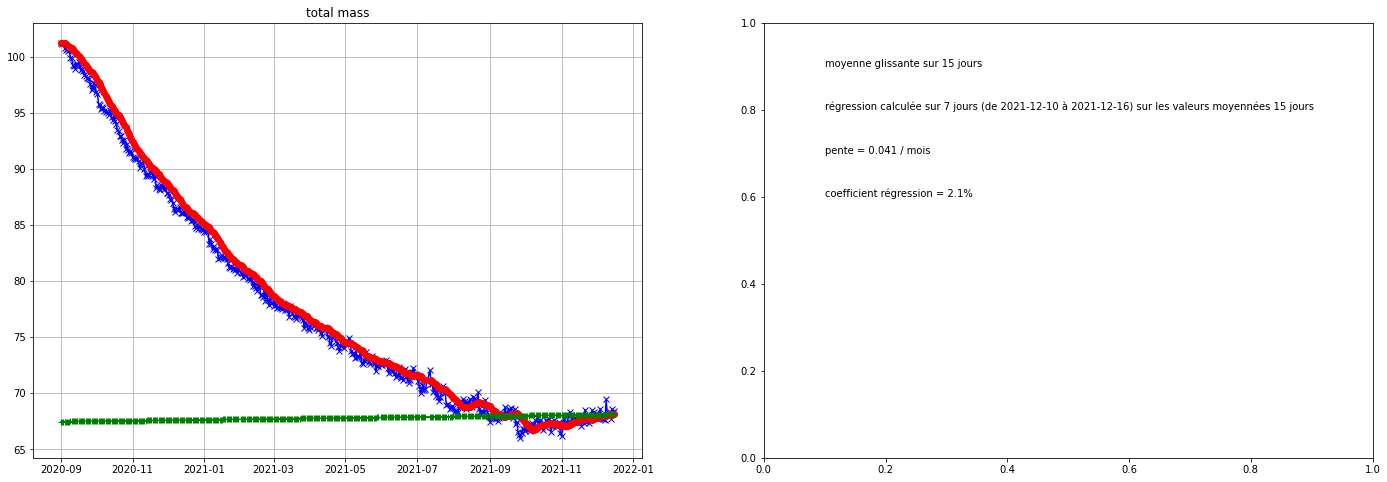

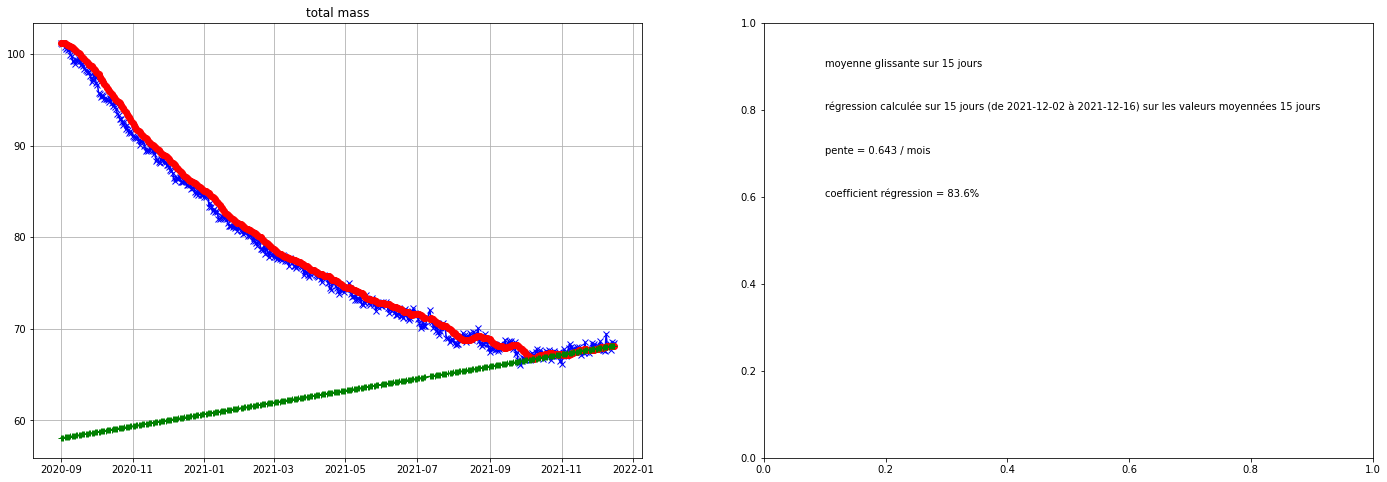

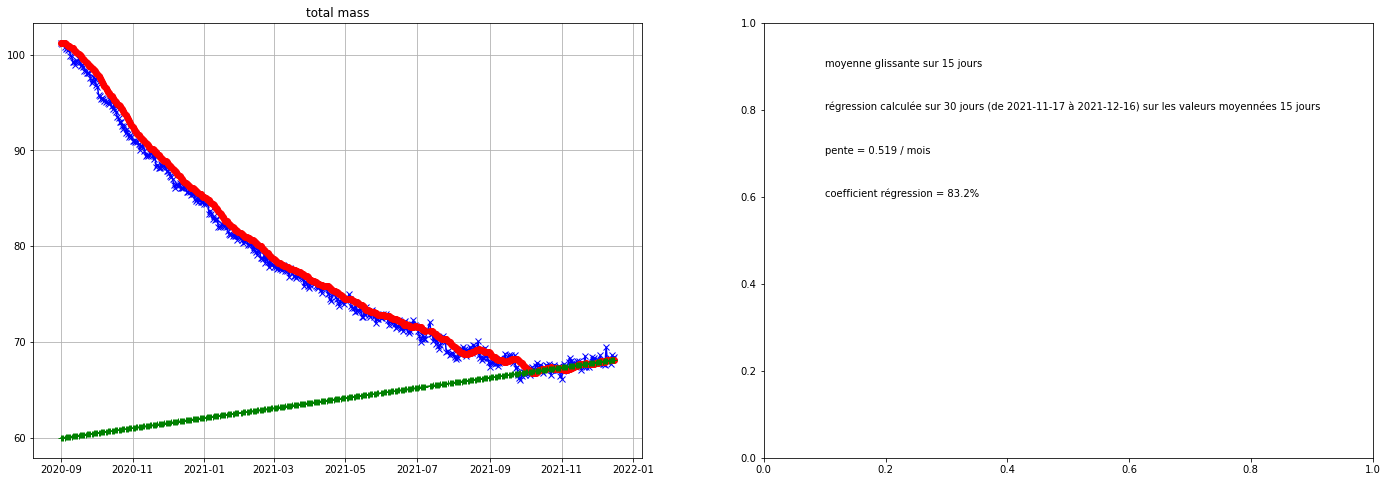

In [10]:
for n_reg in n_reg_list:
    graph.plot_weight(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)

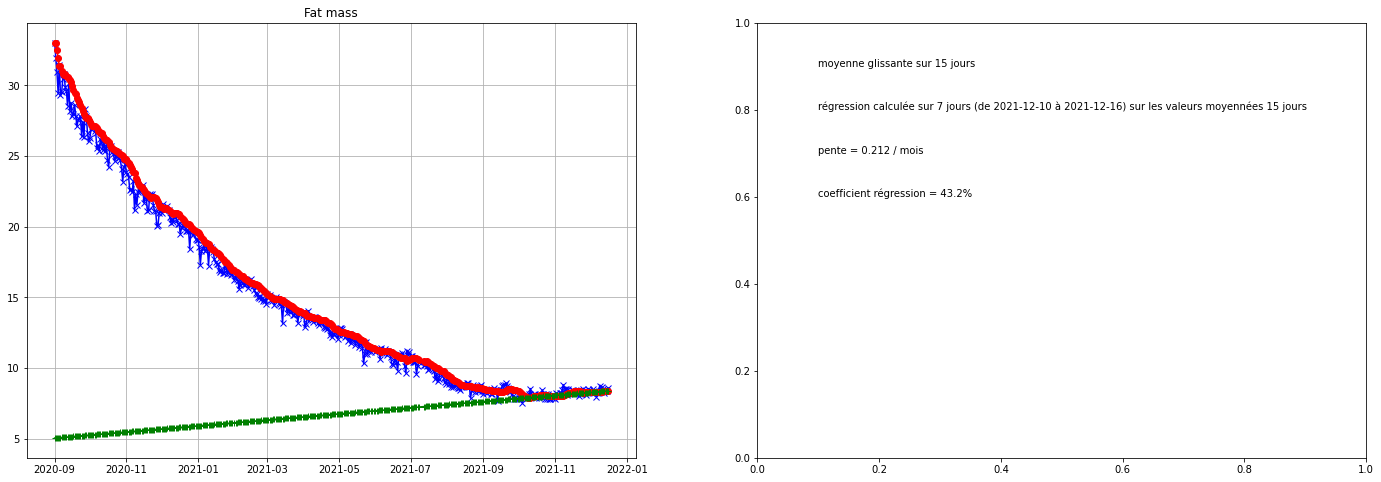

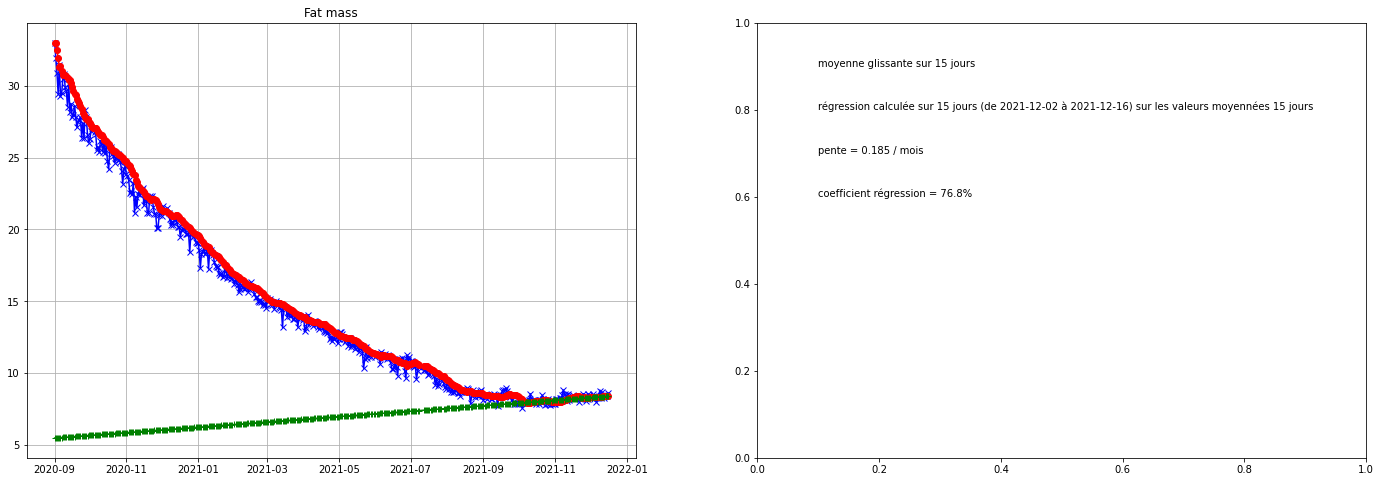

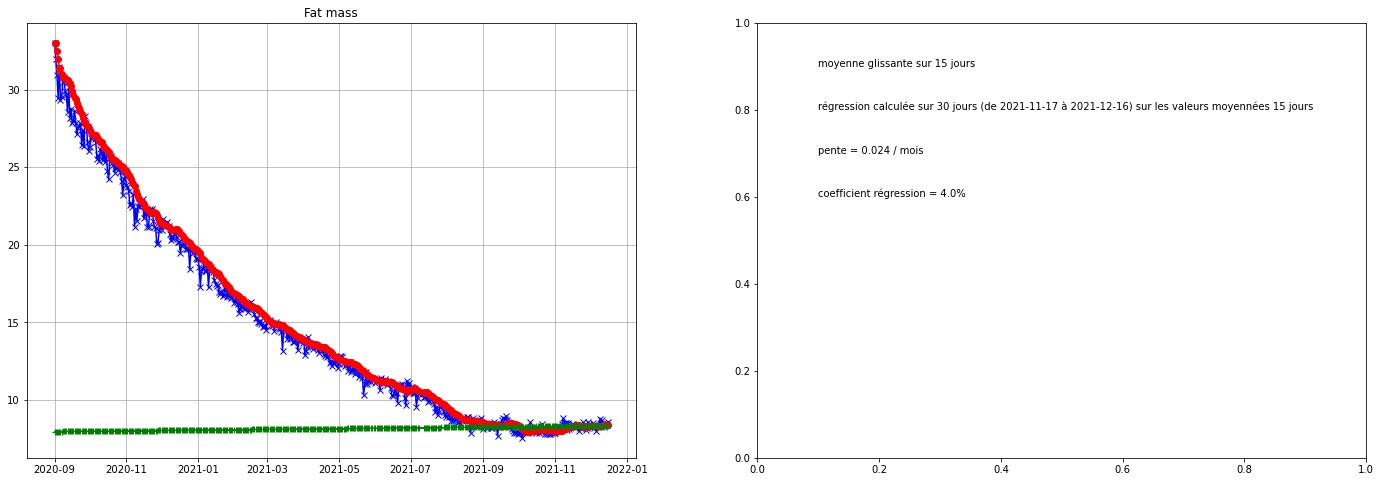

In [11]:
for n_reg in n_reg_list:
    graph.plot_fat(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)

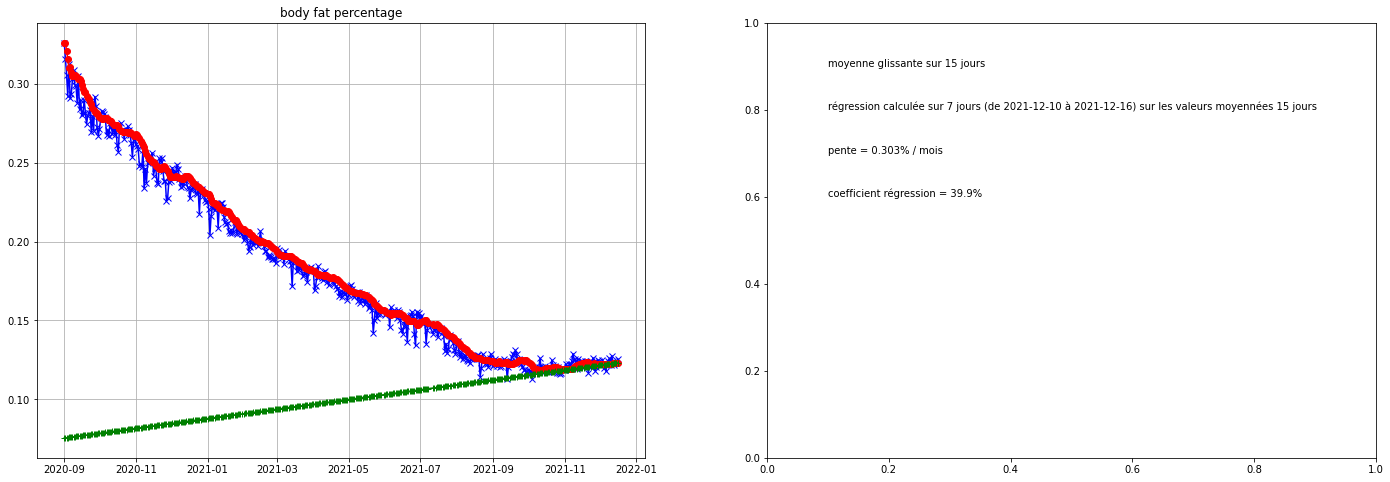

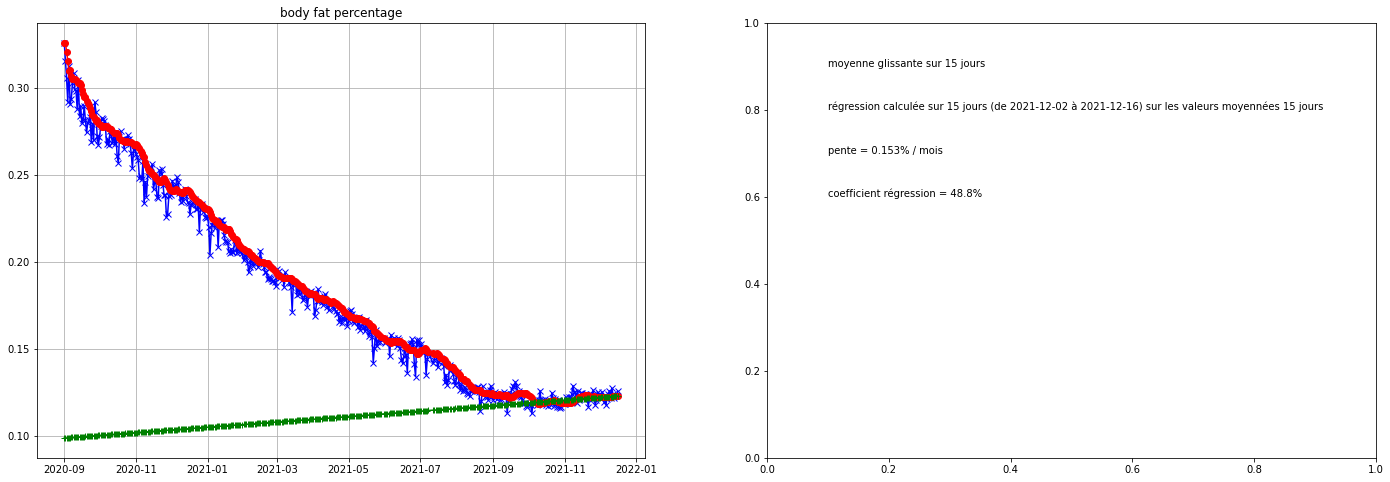

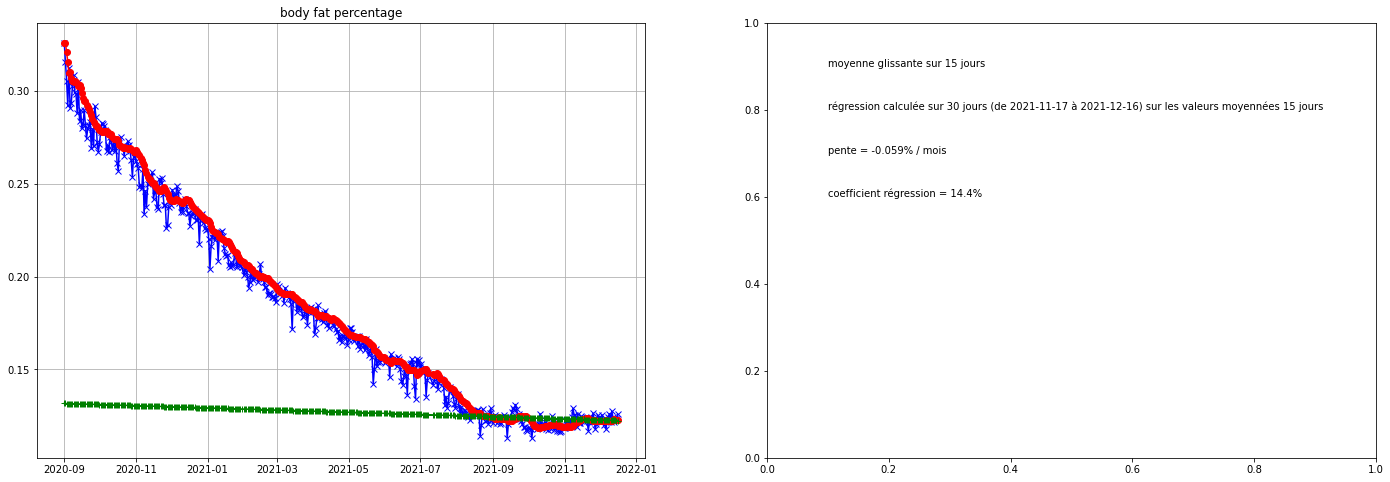

In [12]:
for n_reg in n_reg_list:
    graph.plot_body_fat_percentage(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)

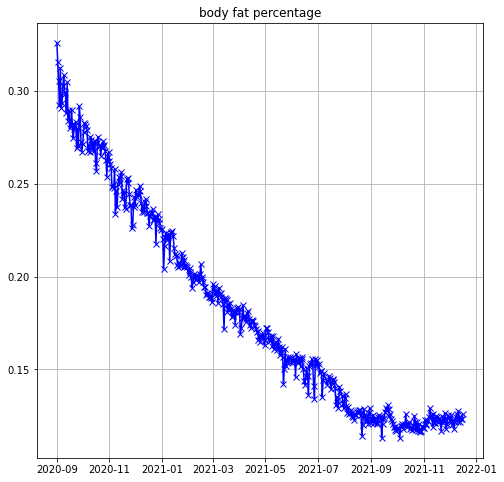

In [13]:
graph.plot_body_fat_percentage(rolling_average=False, n_avg=15, linear_regression=False, n_reg=n_reg)

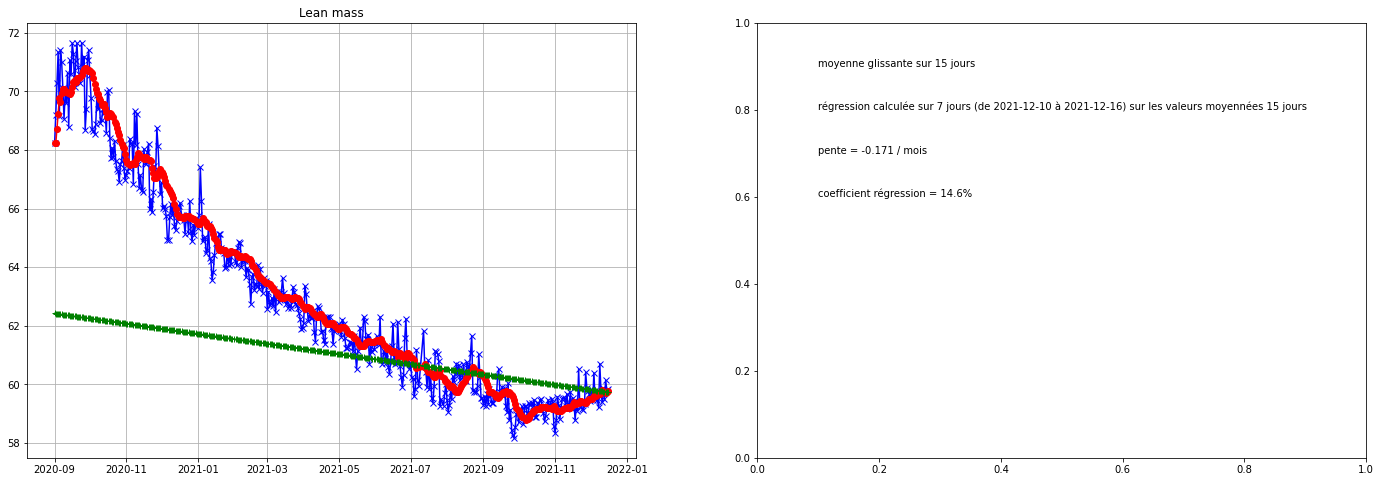

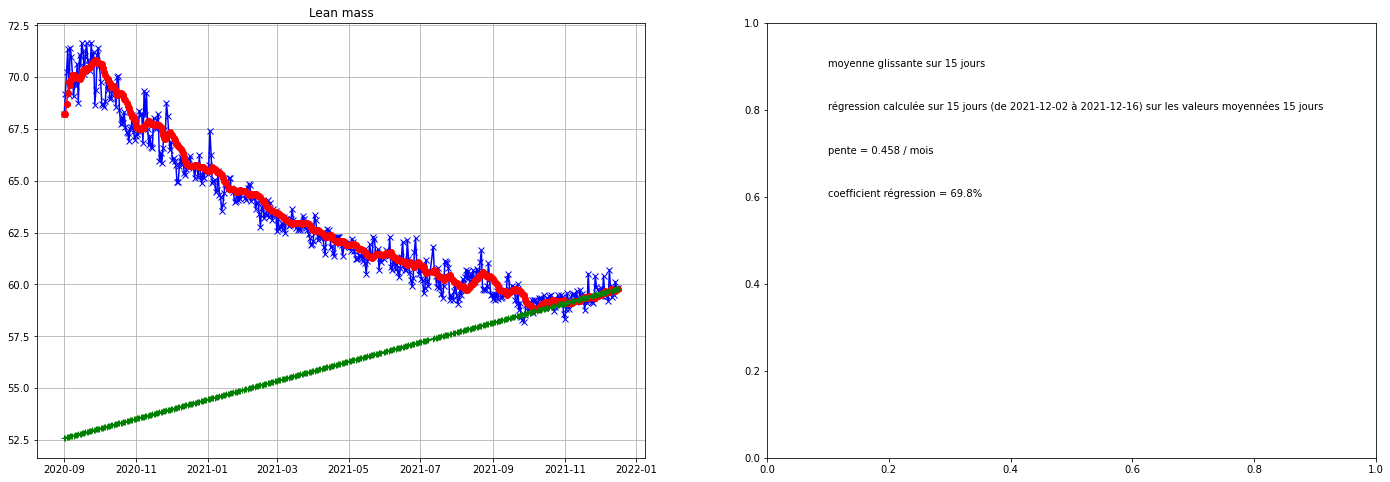

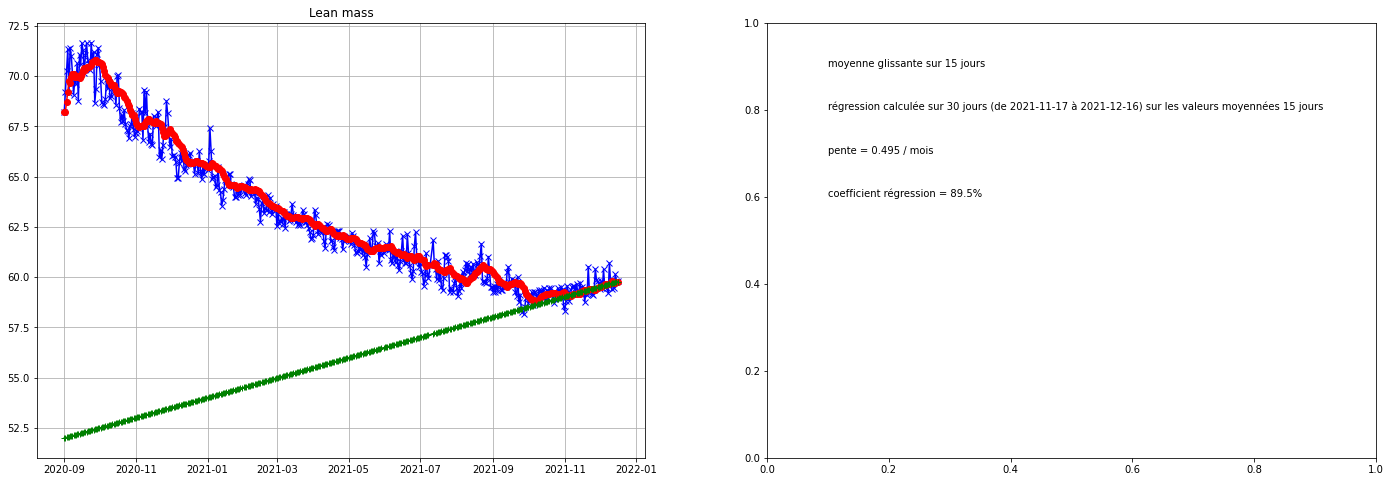

In [14]:
for n_reg in n_reg_list:
    graph.plot_lean_mass(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)

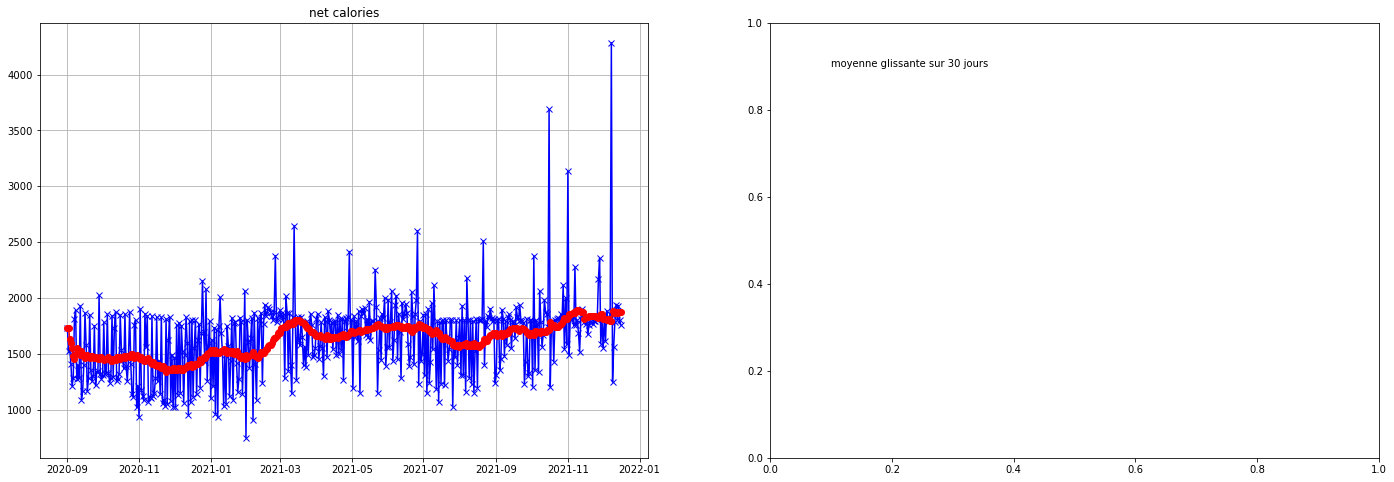

In [15]:
graph.plot_calories_net(rolling_average=True, n_avg=30)

# Zoom 90 jours

In [16]:
over_last_days = 90

window_daily_mass_measurements = ds.get_window_daily_mass_measurements(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )
window_daily_data = ds.get_window_daily_data(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )

graph = Display(window_daily_mass_measurements, window_daily_data)

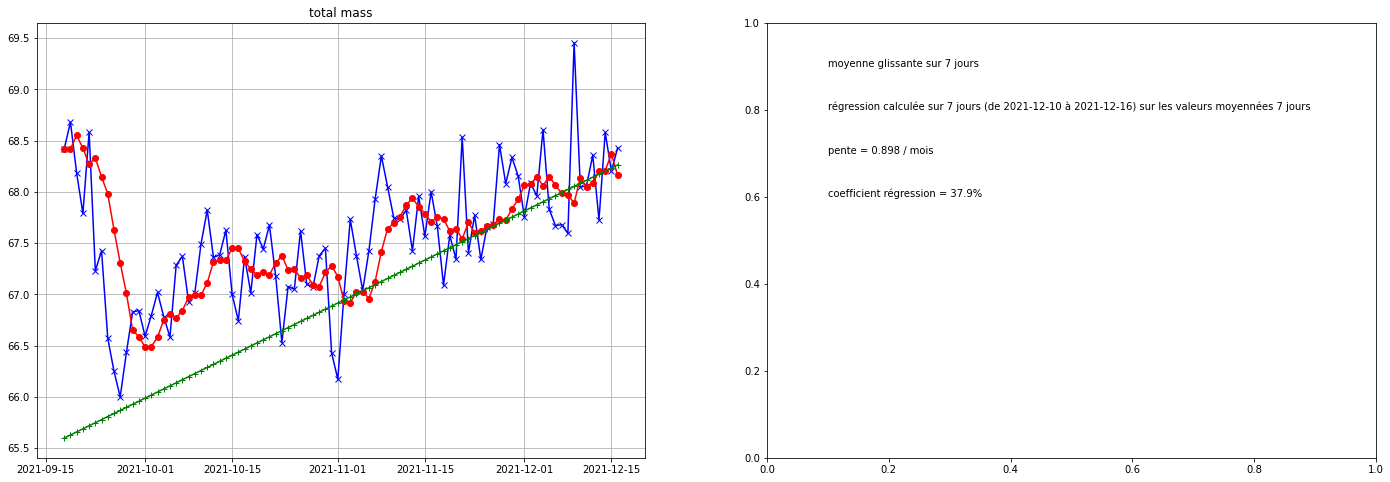

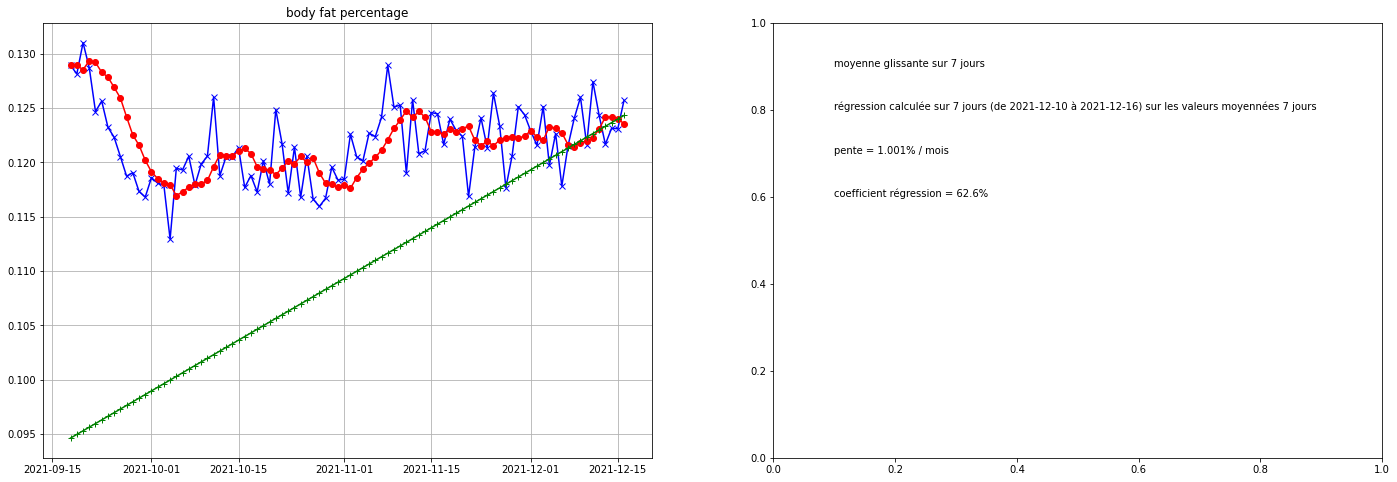

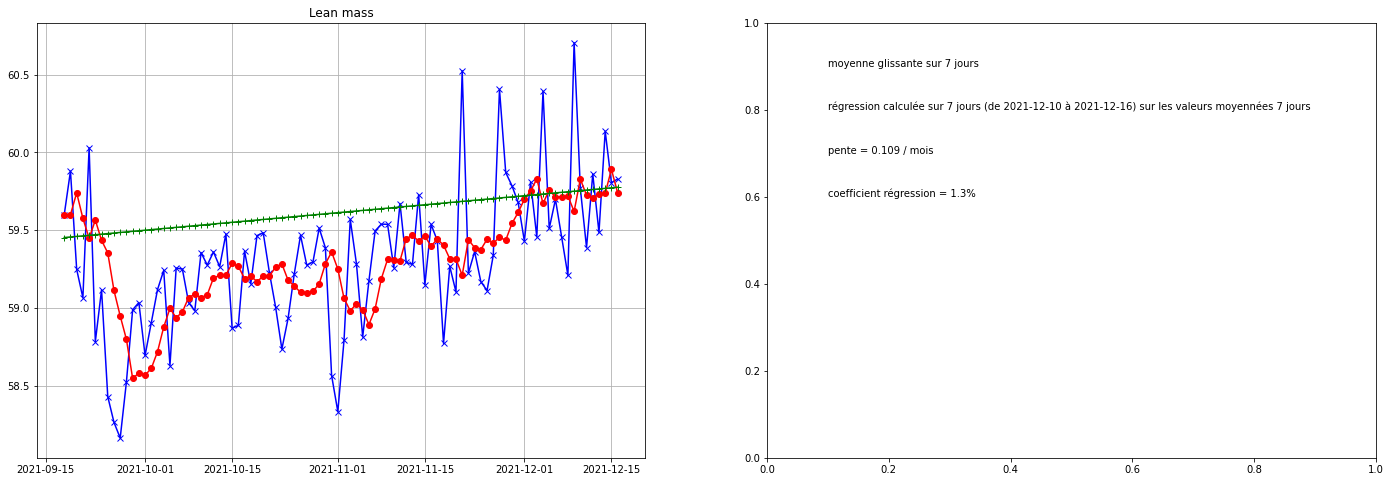

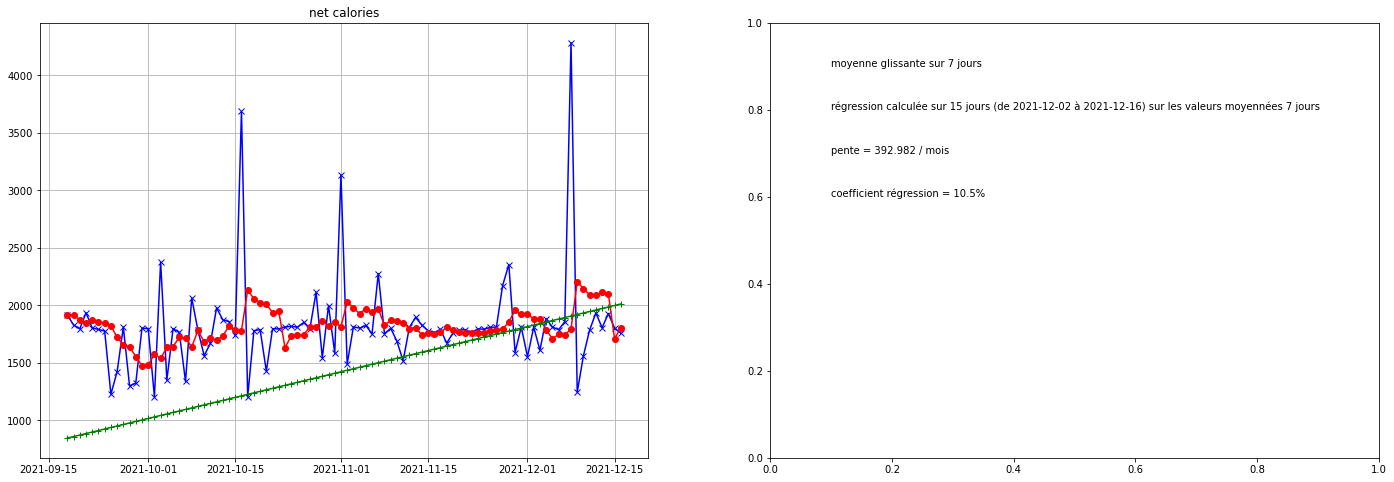

In [18]:
n_reg_list = [7]

for n_reg in n_reg_list:
    graph.plot_weight(rolling_average=True, n_avg=7, linear_regression=True, n_reg=n_reg)
    graph.plot_body_fat_percentage(rolling_average=True, n_avg=7, linear_regression=True, n_reg=n_reg)
    graph.plot_lean_mass(rolling_average=True, n_avg=7, linear_regression=True, n_reg=n_reg)
    
graph.plot_calories_net(rolling_average=True, n_avg=7, linear_regression=True, n_reg=15)
